In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np


In [8]:
# Data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder("dataset/train", transform=transform)
val_dataset = datasets.ImageFolder("dataset/val", transform=transform)
test_dataset = datasets.ImageFolder("dataset/test", transform=transform)

# Create DataLoaders with optimized settings
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


In [9]:
class ImprovedPlantClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedPlantClassifier, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Convolutional Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Convolutional Block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # Adaptive Pooling and Fully Connected Layers
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # Pooling and Fully Connected Layers
        x = self.pool(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 30
model = ImprovedPlantClassifier(num_classes=num_classes).to(device)


In [10]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [11]:
from torch.cuda.amp import GradScaler, autocast

# Initialize GradScaler
scaler = GradScaler()

# Training function with mixed precision
def train_with_amp(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with autocast():  # Enable Mixed Precision
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Backpropagation with GradScaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

# Validation function
def validate_with_amp(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy


C:\Users\anirv\AppData\Local\Temp\ipykernel_24856\3052154416.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [12]:
# Initialize TensorBoard writer
writer = SummaryWriter('runs/improved_plant_classifier')

# Training loop
num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_with_amp(model, train_loader, optimizer, criterion)
    val_loss, val_accuracy = validate_with_amp(model, val_loader, criterion)
    scheduler.step()
    
    # Log metrics to TensorBoard
    writer.add_scalar('Training Loss', train_loss, epoch)
    writer.add_scalar('Validation Loss', val_loss, epoch)
    writer.add_scalar('Training Accuracy', train_accuracy, epoch)
    writer.add_scalar('Validation Accuracy', val_accuracy, epoch)
    
    # Store metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), 'improved_plant_classifier_amp.pth')
print("Model saved!")


C:\Users\anirv\AppData\Local\Temp\ipykernel_24856\3052154416.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable Mixed Precision


Epoch 1/15
Train Loss: 2.9741, Train Accuracy: 14.43%
Val Loss: 2.7182, Val Accuracy: 21.60%
Epoch 2/15
Train Loss: 2.6861, Train Accuracy: 21.38%
Val Loss: 2.6288, Val Accuracy: 24.97%
Epoch 3/15
Train Loss: 2.5109, Train Accuracy: 26.21%
Val Loss: 2.5403, Val Accuracy: 26.83%
Epoch 4/15
Train Loss: 2.3484, Train Accuracy: 30.94%
Val Loss: 2.3592, Val Accuracy: 31.50%
Epoch 5/15
Train Loss: 2.2121, Train Accuracy: 35.05%
Val Loss: 2.2783, Val Accuracy: 34.07%
Epoch 6/15
Train Loss: 2.0272, Train Accuracy: 40.53%
Val Loss: 1.9440, Val Accuracy: 43.37%
Epoch 7/15
Train Loss: 1.9360, Train Accuracy: 43.55%
Val Loss: 1.7583, Val Accuracy: 48.70%
Epoch 8/15
Train Loss: 1.8720, Train Accuracy: 45.00%
Val Loss: 1.7126, Val Accuracy: 50.53%
Epoch 9/15
Train Loss: 1.8124, Train Accuracy: 46.43%
Val Loss: 1.6951, Val Accuracy: 50.73%
Epoch 10/15
Train Loss: 1.7519, Train Accuracy: 48.29%
Val Loss: 1.6975, Val Accuracy: 50.57%
Epoch 11/15
Train Loss: 1.6545, Train Accuracy: 51.16%
Val Loss: 1.47

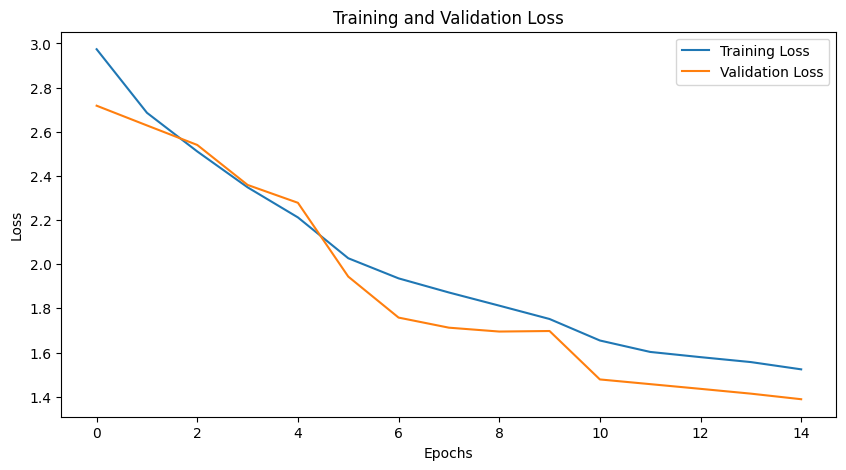

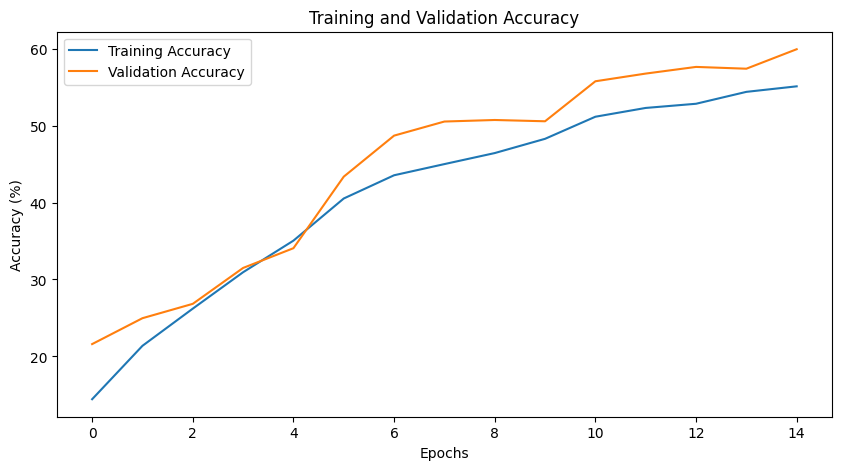

In [13]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Classification Report:
               precision    recall  f1-score   support

     aloevera       0.66      0.56      0.61       200
       banana       0.42      0.52      0.47       200
      bilimbi       0.26      0.33      0.29       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.51      0.54      0.52       200
      coconut       0.38      0.23      0.29       200
         corn       0.61      0.77      0.68       200
     cucumber       0.76      0.70      0.73       200
      curcuma       0.58      0.73      0.65       200
     eggplant       0.59      0.62      0.61       200
     galangal       0.56      0.77      0.64       200
       ginger       0.53      0.42      0.47       200
        guava       0.74      0.61      0.67       200
         kale       0.82      0.39      0.52       200
    longbeans       0.85      0.71      0.78       200
        mango       0.28      0.18      0.22       200
        melon       0.44      0.74      0

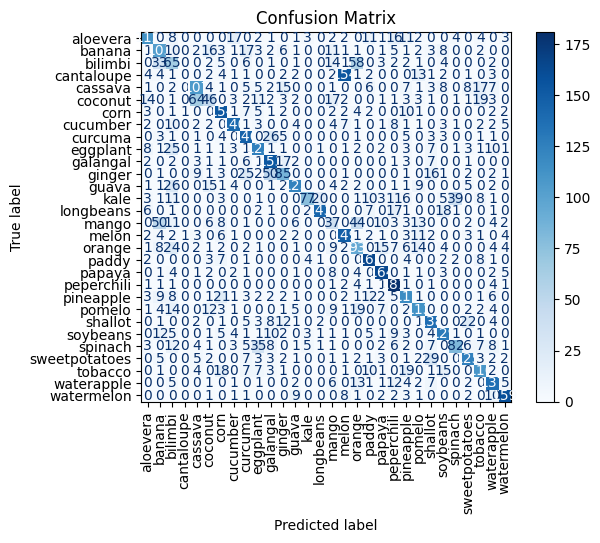

F1 Score (Macro): 0.5652
F1 Score (Micro): 0.5797
F1 Score (Weighted): 0.5652


In [14]:
# Evaluate on test data
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

# F1 Score
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")


In [1]:
import torch 
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>